In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
path = '/content/gdrive/MyDrive/소융캡/dataset_1m/'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import io
import torch
import scipy.sparse as sp

import os
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [ ]:
ratings = pd.read_csv(path + "ratings.dat", sep="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "Timestamp"])

In [ ]:
# users = pd.read_csv(path + "users.dat", sep="::", engine="python",
#                     names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [ ]:
movies = pd.read_csv(path + "movies.dat", sep="::", engine="python", encoding="ISO-8859-1",
                     names=["MovieID", "Title", "Genres"])

In [ ]:
ratings

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [ ]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


# GAN 들어가기 앞서

## 데이터 전처리

In [ ]:
#평점 df
movie_id_list = movies['MovieID'].tolist()
ratings_df = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value = 0)
ratings_df = ratings_df.reindex(columns=movie_id_list, fill_value=0)

In [ ]:
#결측 df
missing_df = ratings_df.applymap(lambda x: 1 if x > 0 else 0)

## train test split

In [ ]:
from sklearn.model_selection import train_test_split

X = missing_df
y = ratings_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4832, 3883), (1208, 3883), (4832, 3883), (1208, 3883))

# GAN

##평점벡터

In [ ]:
latent_dim = 100
output_dim = 3883
epochs = 50
batch_size = 128
lr_d = 0.00005
lr_g = 0.00003
n_iter_D = 1
n_iter_G = 1

In [ ]:
# 생성자 모델
Generator = Sequential()
Generator.add(Dense(128, input_shape=(latent_dim,), activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())

Generator.add(Dense(512, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())
Generator.add(Dropout(0.3))

Generator.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())
Generator.add(Dropout(0.3))

#output_dim보다 커야함
Generator.add(Dense(4096, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())

Generator.add(Dense(output_dim, activation='relu'))


# 판별자 모델
Discriminator = Sequential()
Discriminator.add(Dense(1028, input_shape=(output_dim,), activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())

Discriminator.add(Dense(512, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(256, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(128, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(1, activation='sigmoid'))


Doptimizer = tf.keras.optimizers.Adam(lr_d)
Goptimizer = tf.keras.optimizers.Adam(lr_g)


def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

loss_D_list = []
loss_G_list = []
loss_GD_list = []

for epoch in tf.range(epochs):
    batch_input = y_train.sample(n=batch_size)
    missing = batch_input.applymap(lambda x: 1 if x > 0 else 0)

    inputs = tf.Variable(batch_input.values, tf.float32)
    missing_array = tf.Variable(missing.values, tf.float32)
    inputs = tf.cast(inputs, tf.float32)
    missing_array = tf.cast(missing_array, tf.float32)

    #with tf.GradientTape() as t1, tf.GradientTape() as t2:
    with tf.GradientTape(persistent=True) as t1, tf.GradientTape(persistent=True) as t2:


      for iter in range(n_iter_G):
        generated_data = Generator(get_noise(batch_size,latent_dim))
        G = generated_data * missing_array
        Z = Discriminator(G)
        loss_G = -tf.reduce_mean(tf.math.log(Z))
        Ggradients = t2.gradient(loss_G,Generator.trainable_variables)
        #inf 방지??
        Ggradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients]
        Goptimizer.apply_gradients(zip(Ggradients, Generator.trainable_variables))

      for iter in range(n_iter_D):
        generated_data = Generator(get_noise(batch_size,latent_dim))
        G = generated_data * missing_array
        Z = Discriminator(G)
        R = Discriminator(inputs)
        # 둘 다 minimize
        loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))
        #loss_G = -tf.reduce_mean(tf.math.log(Z))
        Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
        #inf 방지??
        Dgradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Dgradients]
        Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))

    loss_D_list.append(loss_D)
    loss_G_list.append(loss_G)
    loss_GD_list.append(loss_D+loss_G)

    print(f'Epoch: {epoch}, Discriminator Loss: {loss_D}, Generator Loss: {loss_G}, GAN Loss: {loss_D+loss_G}')
    #print(f"epoch: {epoch} d_loss: {loss_D} g_loss: {loss_G}")

Epoch: 0, Discriminator Loss: 1.365437626838684, Generator Loss: 0.6920785903930664, GAN Loss: 2.057516098022461
Epoch: 1, Discriminator Loss: 1.1871083974838257, Generator Loss: 0.6887375712394714, GAN Loss: 1.8758459091186523
Epoch: 2, Discriminator Loss: 1.0647296905517578, Generator Loss: 0.6847413778305054, GAN Loss: 1.7494710683822632
Epoch: 3, Discriminator Loss: 1.011284351348877, Generator Loss: 0.6825288534164429, GAN Loss: 1.6938132047653198
Epoch: 4, Discriminator Loss: 0.9559937715530396, Generator Loss: 0.6800899505615234, GAN Loss: 1.636083722114563
Epoch: 5, Discriminator Loss: 0.9278643727302551, Generator Loss: 0.6763563752174377, GAN Loss: 1.6042207479476929
Epoch: 6, Discriminator Loss: 0.925512433052063, Generator Loss: 0.6749981641769409, GAN Loss: 1.600510597229004
Epoch: 7, Discriminator Loss: 0.8832108974456787, Generator Loss: 0.6703493595123291, GAN Loss: 1.5535602569580078
Epoch: 8, Discriminator Loss: 0.8720709085464478, Generator Loss: 0.6580626964569092, 

epoch 50 : 3분 25초

두 손실 함수 중 하나만 감소하는 것을 선택하는 것은 상황에 따라 다릅니다. 예를 들어, loss_g만 감소하면서 loss_d가 증가하는 경우, 생성자가 더 이상 학습할 부분이 없어지거나 과적합(overfitting)이 발생할 가능성이 높습니다. 따라서 이러한 상황에서는 loss_d를 개선하기 위한 추가적인 학습 전략이 필요합니다.

반면에, loss_d만 감소하면서 loss_g가 증가하는 경우, 생성자가 더 많은 학습을 진행해야 하며, 이러한 상황에서는 생성자의 학습률(learning rate)을 조절하여 개선할 수 있습니다.

loss의 주기성은 g와 d의 레이어 개수가 다르면 발생할 수 있다.

In [ ]:
df_ratings_create = pd.DataFrame(generated_data, columns = ratings_df.columns)
df_ratings_create.index = range(10001, 10001+len(df_ratings_create))
df_ratings_create = df_ratings_create.rename_axis("UserID")

In [ ]:
df_ratings_create

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
10001,2.164404,0.0,2.184308,0.0,0.387375,0.0,0.0,1.030177,0.0,2.026569,...,0.380965,0.509985,0.474416,0.700040,0.000000,0.0,0.0,0.0,0.0,1.161364
10002,2.329031,0.0,2.330387,0.0,0.447905,0.0,0.0,1.213352,0.0,1.940059,...,0.448723,0.604182,0.723259,0.649920,0.035680,0.0,0.0,0.0,0.0,1.255777
10003,2.320044,0.0,2.234044,0.0,0.506705,0.0,0.0,1.211802,0.0,1.901901,...,0.593742,0.615002,0.482156,0.646208,0.000000,0.0,0.0,0.0,0.0,1.227699
10004,1.390875,0.0,1.283723,0.0,0.304790,0.0,0.0,0.728829,0.0,1.389306,...,0.210976,0.400674,0.342160,0.486040,0.049585,0.0,0.0,0.0,0.0,0.665430
10005,3.007695,0.0,2.974615,0.0,0.521294,0.0,0.0,1.667266,0.0,2.710983,...,0.582751,0.910538,0.722645,1.005360,0.000000,0.0,0.0,0.0,0.0,1.505903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1.991547,0.0,2.127188,0.0,0.368272,0.0,0.0,1.013926,0.0,1.976330,...,0.389506,0.751640,0.569566,0.721125,0.000000,0.0,0.0,0.0,0.0,1.029303
10125,2.114745,0.0,1.910591,0.0,0.403717,0.0,0.0,1.047790,0.0,1.877209,...,0.543008,0.562909,0.554168,0.614073,0.000000,0.0,0.0,0.0,0.0,1.018037
10126,2.011510,0.0,2.023024,0.0,0.333793,0.0,0.0,1.229498,0.0,1.798581,...,0.343940,0.609165,0.482055,0.703604,0.003336,0.0,0.0,0.0,0.0,1.139730


In [ ]:
max_val = df_ratings_create.max().max()
print(max_val)

5.9351025


In [ ]:
zero_cols = (df_ratings_create == 0).all(axis=0).sum()
print(zero_cols)

1199


In [ ]:
df = df_ratings_create.copy()

In [ ]:
#저장
df.to_csv(path + 'df.csv', index=False)

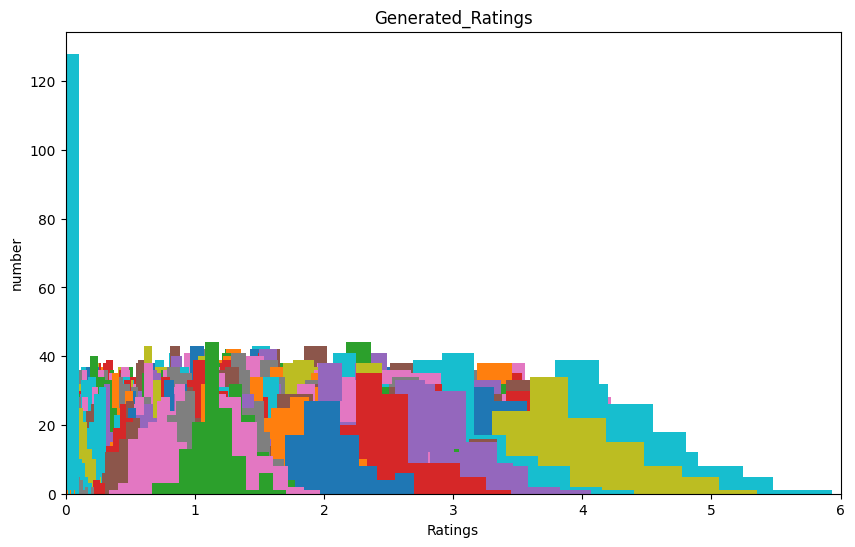

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df.columns:
  plt.hist(df[column_name])
plt.xlim(0, 6)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

<Axes: xlabel='MovieID', ylabel='UserID'>

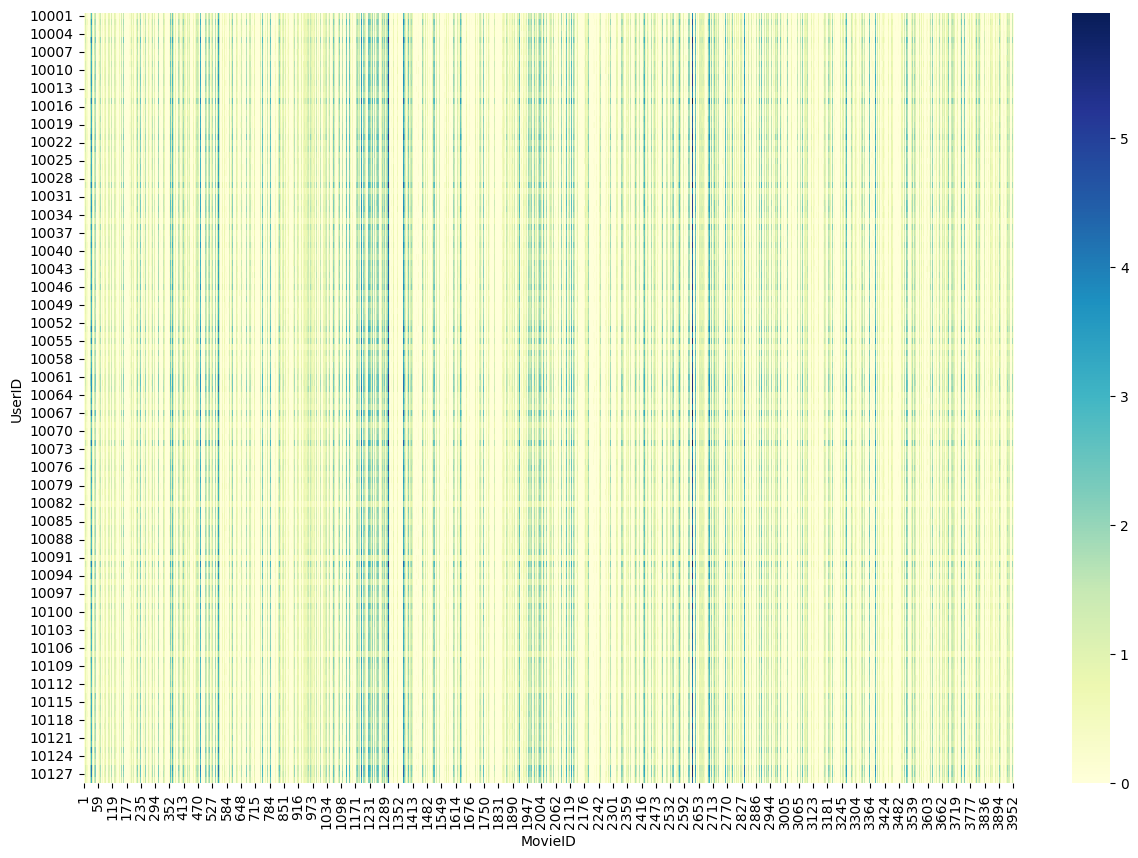

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df, cmap='YlGnBu', ax=ax)

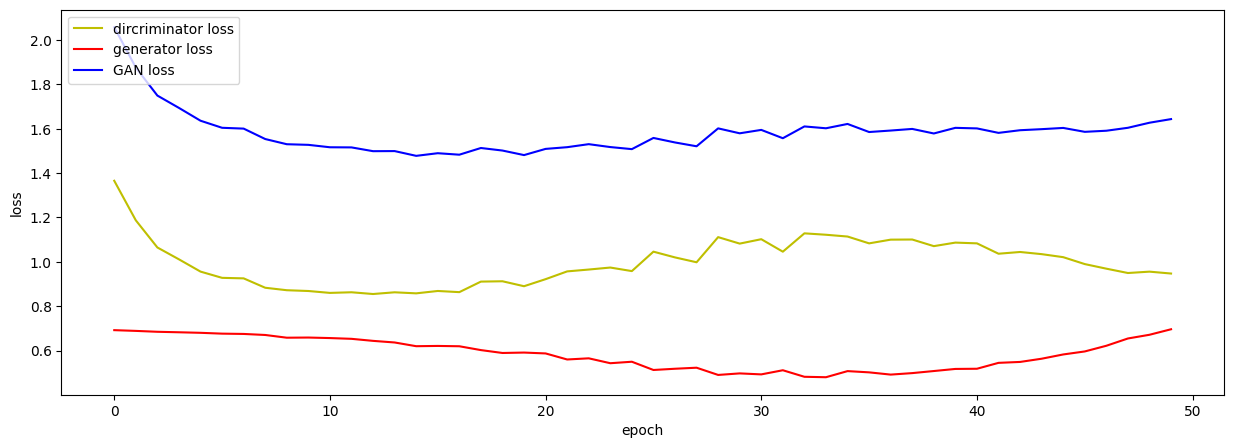

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(loss_D_list, 'y', label = 'dircriminator loss')
loss_ax.plot(loss_G_list, 'r', label = 'generator loss')
loss_ax.plot(loss_GD_list, 'b', label = 'GAN loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
# 모델 저장
Generator.save('/content/gdrive/MyDrive/소융캡/generator_ratings.h5')

##결측벡터

In [ ]:
latent_dim = 100
output_dim = 3883
epochs = 50
batch_size = 128
lr_d = 0.00005
lr_g = 0.00003
n_iter_D = 2
n_iter_G = 1

In [ ]:
# 생성자 모델
Generator_fake = Sequential()
Generator_fake.add(Dense(128, input_shape=(latent_dim,), activation=LeakyReLU(0.2)))
Generator_fake.add(BatchNormalization())

Generator_fake.add(Dense(512, activation=LeakyReLU(0.2)))
Generator_fake.add(BatchNormalization())
Generator_fake.add(Dropout(0.3))

Generator_fake.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator_fake.add(BatchNormalization())
Generator_fake.add(Dropout(0.3))

#output_dim보다 커야함
Generator_fake.add(Dense(4096, activation=LeakyReLU(0.2)))
Generator_fake.add(BatchNormalization())

Generator_fake.add(Dense(output_dim, activation='relu'))


# 판별자 모델
Discriminator = Sequential()
Discriminator.add(Dense(1028, input_shape=(output_dim,), activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())

Discriminator.add(Dense(512, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(256, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(128, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(1, activation='sigmoid'))


Doptimizer = tf.keras.optimizers.Adam(lr_d)
Goptimizer = tf.keras.optimizers.Adam(lr_g)


def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

loss_D_list = []
loss_G_list = []
loss_GD_list = []

for epoch in tf.range(epochs):
    batch_input = X_train.sample(n=batch_size)

    inputs = tf.Variable(batch_input.values, tf.float32)
    inputs = tf.cast(inputs, tf.float32)

    #with tf.GradientTape() as t1, tf.GradientTape() as t2:
    with tf.GradientTape(persistent=True) as t1, tf.GradientTape(persistent=True) as t2:


      for iter in range(n_iter_G):
        generated_data = Generator_fake(get_noise(batch_size,latent_dim))
        Z = Discriminator(generated_data)
        loss_G = -tf.reduce_mean(tf.math.log(Z))
        Ggradients = t2.gradient(loss_G,Generator_fake.trainable_variables)
        #inf 방지??
        Ggradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients]
        Goptimizer.apply_gradients(zip(Ggradients, Generator_fake.trainable_variables))

      for iter in range(n_iter_D):
        generated_data = Generator_fake(get_noise(batch_size,latent_dim))
        Z = Discriminator(generated_data)
        R = Discriminator(inputs)
        # 둘 다 minimize
        loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))
        #loss_G = -tf.reduce_mean(tf.math.log(Z))
        Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
        #inf 방지??
        Dgradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Dgradients]
        Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))

    loss_D_list.append(loss_D)
    loss_G_list.append(loss_G)
    loss_GD_list.append(loss_D+loss_G)

    print(f'Epoch: {epoch}, Discriminator Loss: {loss_D}, Generator Loss: {loss_G}, GAN Loss: {loss_D+loss_G}')
    #print(f"epoch: {epoch} d_loss: {loss_D} g_loss: {loss_G}")

Epoch: 0, Discriminator Loss: 1.4470388889312744, Generator Loss: 0.7219929695129395, GAN Loss: 2.169031858444214
Epoch: 1, Discriminator Loss: 1.389548420906067, Generator Loss: 0.6914660334587097, GAN Loss: 2.081014394760132
Epoch: 2, Discriminator Loss: 1.3369536399841309, Generator Loss: 0.6763084530830383, GAN Loss: 2.0132620334625244
Epoch: 3, Discriminator Loss: 1.3003826141357422, Generator Loss: 0.6643413305282593, GAN Loss: 1.9647239446640015
Epoch: 4, Discriminator Loss: 1.2674771547317505, Generator Loss: 0.6567646861076355, GAN Loss: 1.9242417812347412
Epoch: 5, Discriminator Loss: 1.2254059314727783, Generator Loss: 0.65177983045578, GAN Loss: 1.8771858215332031
Epoch: 6, Discriminator Loss: 1.2114126682281494, Generator Loss: 0.6488381624221802, GAN Loss: 1.8602508306503296
Epoch: 7, Discriminator Loss: 1.1879408359527588, Generator Loss: 0.649976909160614, GAN Loss: 1.8379178047180176
Epoch: 8, Discriminator Loss: 1.1461551189422607, Generator Loss: 0.6548712253570557, 

In [ ]:
df_missing_create = pd.DataFrame(generated_data, columns = ratings_df.columns)
df_missing_create.index = range(10001, 10001+len(df_missing_create))
df_missing_create = df_missing_create.rename_axis("UserID")

In [ ]:
df_missing_create

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
10001,0.107109,0.074340,0.115217,0.0,0.000000,0.083037,0.003902,0.000000,0.004392,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000
10002,0.197187,0.109545,0.192499,0.0,0.000000,0.045531,0.076037,0.000000,0.045711,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.006148,0.0,0.0,0.00000,0.000000
10003,0.136840,0.150152,0.202310,0.0,0.000000,0.089152,0.121146,0.002630,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000
10004,0.186342,0.125818,0.156097,0.0,0.000000,0.068183,0.091496,0.043393,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.022315,0.000000,0.0,0.0,0.00000,0.009097
10005,0.011071,0.048438,0.122480,0.0,0.013081,0.110331,0.098248,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,0.080096,0.014367,0.111327,0.0,0.000000,0.048456,0.071243,0.000000,0.055828,0.0,...,0.0,0.000000,0.0,0.0,0.030891,0.000000,0.0,0.0,0.00000,0.000000
10125,0.012802,0.057042,0.080463,0.0,0.004965,0.068529,0.082469,0.000000,0.000000,0.0,...,0.0,0.019193,0.0,0.0,0.088029,0.000000,0.0,0.0,0.00000,0.000000
10126,0.095936,0.078155,0.052159,0.0,0.000000,0.081962,0.116383,0.000000,0.043447,0.0,...,0.0,0.000000,0.0,0.0,0.024258,0.000000,0.0,0.0,0.00000,0.000000


In [ ]:
max_val = df_missing_create.max().max()
print(max_val)

0.56046164


In [ ]:
zero_cols = (df_missing_create == 0).all(axis=0).sum()
print(zero_cols)

676


In [ ]:
df_missing = df_missing_create.copy()

In [ ]:
df_missing.to_csv(path + 'df_missing.csv', index=False)

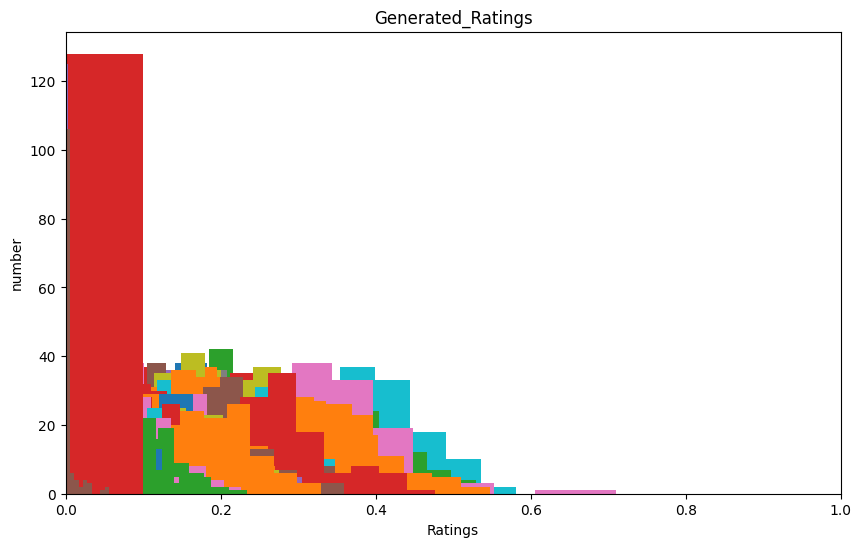

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df_missing.columns:
  plt.hist(df_missing[column_name])
plt.xlim(0, 1)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

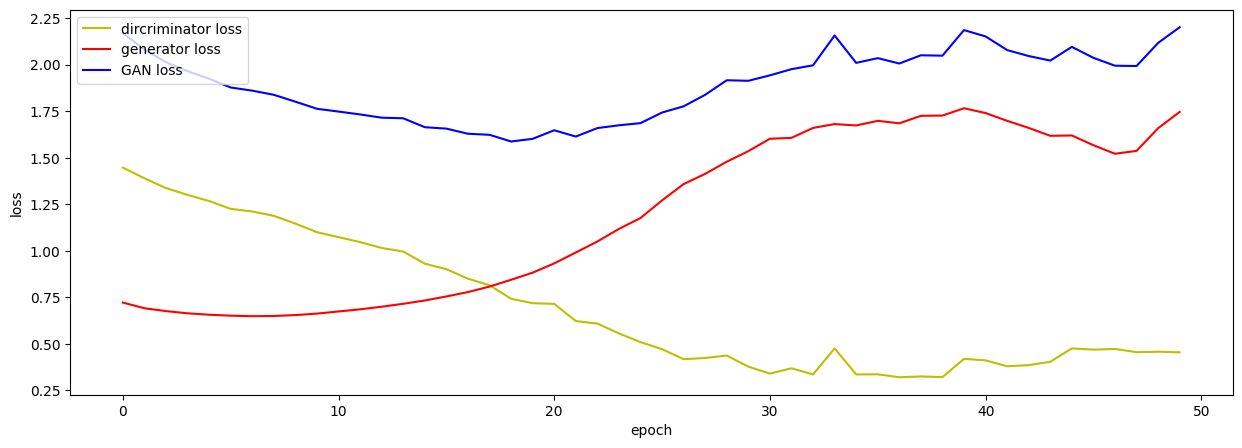

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(loss_D_list, 'y', label = 'dircriminator loss')
loss_ax.plot(loss_G_list, 'r', label = 'generator loss')
loss_ax.plot(loss_GD_list, 'b', label = 'GAN loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
# 모델 저장
Generator_fake.save('/content/gdrive/MyDrive/소융캡/generator_missing.h5')

## 둘이 합치기

In [ ]:
df = pd.read_csv(path + 'df.csv')
df_missing = pd.read_csv(path + 'df_missing.csv')

In [ ]:
df

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,3.183490,0.935007,1.648902,0.0,0.0,2.156809,1.039504,0.941542,0.0,1.922148,...,0.0,0.0,0.0,0.830314,0.0,1.315674,0.105796,0.0,0.0,0.0
1,4.033639,0.948156,2.067377,0.0,0.0,2.876275,1.194977,1.293240,0.0,2.407170,...,0.0,0.0,0.0,1.016418,0.0,1.460905,0.000000,0.0,0.0,0.0
2,3.240699,1.046382,1.871159,0.0,0.0,2.349153,1.123688,1.005807,0.0,2.139540,...,0.0,0.0,0.0,0.807247,0.0,1.406264,0.000000,0.0,0.0,0.0
3,3.164995,0.872687,1.697020,0.0,0.0,2.227464,1.071367,0.841108,0.0,2.024266,...,0.0,0.0,0.0,0.835464,0.0,1.417332,0.014005,0.0,0.0,0.0
4,4.575909,1.231814,2.323828,0.0,0.0,3.141922,1.430309,1.366636,0.0,2.867755,...,0.0,0.0,0.0,1.206033,0.0,1.968708,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,3.735405,1.131685,1.960139,0.0,0.0,2.530974,1.062864,1.094206,0.0,2.316194,...,0.0,0.0,0.0,1.131987,0.0,1.414476,0.111323,0.0,0.0,0.0
124,3.420942,0.987566,1.677600,0.0,0.0,2.362683,1.105213,0.825324,0.0,2.060761,...,0.0,0.0,0.0,0.919750,0.0,1.362141,0.063923,0.0,0.0,0.0
125,4.884240,1.289308,2.502110,0.0,0.0,3.526764,1.554880,1.260745,0.0,3.095705,...,0.0,0.0,0.0,1.192717,0.0,1.910210,0.000000,0.0,0.0,0.0
126,4.608130,1.236723,2.431184,0.0,0.0,3.308710,1.357902,1.352042,0.0,2.942385,...,0.0,0.0,0.0,1.022922,0.0,1.795195,0.000000,0.0,0.0,0.0


missing_df에 ['1':'0'] = [1000209 : 21384031] = [1:21] 비율로 존재

In [ ]:
values_flattened = df_missing.values.flatten()
top_values = sorted(set(values_flattened), reverse=True)[:25000]

In [ ]:
values_flattened = np.where(np.isin(values_flattened, top_values), 1, 0)

# 1차원 배열을 다시 128 * 3706 크기의 데이터프레임으로 변환
df_missing_final = pd.DataFrame(values_flattened.reshape(128, 3706), index=df.index, columns=df.columns)

In [ ]:
df_missing_final

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_final = df_missing_final * df

In [ ]:
df_final = np.ceil(df_final)
df_final[df_final > 5] = 5

In [ ]:
counts = df_final.stack().value_counts()

In [ ]:
counts

0.0    459047
2.0      7030
1.0      3753
3.0      3462
4.0       802
5.0       274
dtype: int64

In [ ]:
df_final = df_final.astype(int)

In [ ]:
df_final

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,2,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,0,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


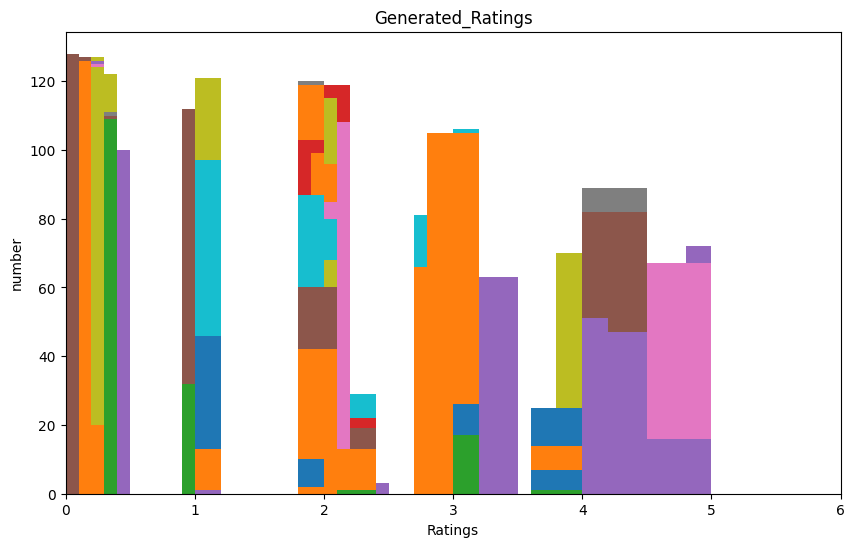

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df_final.columns:
  plt.hist(df_final[column_name])
plt.xlim(0, 6)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

In [ ]:
df_final.index.name = 'UserID'
df_final.columns.name = 'MovieID'
df_final.name = 'Rating'

In [ ]:
df_fake = df_final.reset_index().melt(id_vars='UserID', value_name='Rating', var_name='MovieID').dropna()

In [ ]:
df_fake = df_fake[df_fake['Rating'] != 0]

In [ ]:
df_fake

,UserID,MovieID,Rating
13,13,1,4
33,33,1,4
44,44,1,4
72,72,1,3
73,73,1,4
...,...,...,...
473908,52,3949,1
473930,74,3949,1
473931,75,3949,1
473952,96,3949,1


In [ ]:
df_fake.to_csv(path + 'df_fake.csv', index=False)

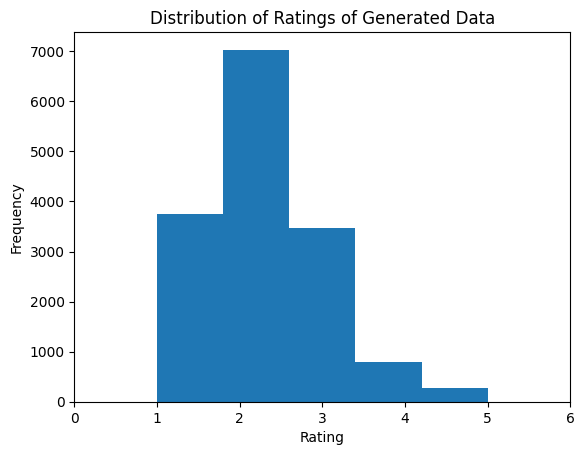

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.hist(df_fake['Rating'], bins = 5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings of Generated Data')
plt.show()

## 양 늘리기 (batch size 조정)


In [ ]:
from tensorflow.keras.models import load_model
generator_ratings = load_model('/content/gdrive/MyDrive/소융캡/generator_ratings.h5')
generator_missing = load_model('/content/gdrive/MyDrive/소융캡/generator_missing.h5')

In [ ]:
batch_size = 4096
latent_dim = 100

In [ ]:
def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

In [ ]:
fake_ratings = generator_ratings(get_noise(batch_size,latent_dim))
fake_missing = generator_missing(get_noise(batch_size,latent_dim))

In [ ]:
df_ratings_create = pd.DataFrame(fake_ratings, columns = ratings_df.columns)
df_ratings_create.index = range(10001, 10001+len(df_ratings_create))
df_ratings_create = df_ratings_create.rename_axis("UserID")

In [ ]:
max_val = df_ratings_create.max().max()
print(max_val)

6.61111


In [ ]:
df_missing_create = pd.DataFrame(fake_missing, columns = ratings_df.columns)
df_missing_create.index = range(10001, 10001+len(df_missing_create))
df_missing_create = df_missing_create.rename_axis("UserID")

In [ ]:
max_val = df_missing_create.max().max()
print(max_val)

0.6485951


missing_df에 ['1':'0'] = [1000209 : 21384031] = [1:21] 비율로 존재

In [ ]:
values_flattened = df_missing_create.values.flatten()  # DataFrame을 1차원 배열로 변환합니다
top_values = sorted(set(values_flattened), reverse=True)[:1000000]

In [ ]:
values_flattened = np.where(np.isin(values_flattened, top_values), 1, 0)

# 1차원 배열을 다시 batchsize * 3883 크기의 데이터프레임으로 변환
df_missing_final = pd.DataFrame(values_flattened.reshape(batch_size, 3883), index=df_missing_create.index, columns=df_missing_create.columns)

In [ ]:
counts = df_missing_final.stack().value_counts()

In [ ]:
counts

0    14853978
1     1050790
dtype: int64

In [ ]:
df_final = df_missing_final * df_ratings_create

In [ ]:
df_final = np.ceil(df_final)
df_final[df_final > 5] = 5

In [ ]:
counts = df_final.stack().value_counts()

In [ ]:
counts

0.0    15203263
2.0      311998
1.0      229117
3.0      119768
4.0       34341
5.0        6281
dtype: int64

In [ ]:
df_final = df_final.astype(int)

In [ ]:
df_final

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
10001,3,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,3,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10005,3,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14093,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14094,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_final.index.name = 'UserID'
df_final.columns.name = 'MovieID'
df_final.name = 'Rating'

In [ ]:
df_fake = df_final.reset_index().melt(id_vars='UserID', value_name='Rating', var_name='MovieID').dropna()

In [ ]:
df_fake = df_fake[df_fake['Rating'] != 0]

In [ ]:
df_fake

,UserID,MovieID,Rating
0,10001,1,3
2,10003,1,3
4,10005,1,3
6,10007,1,2
8,10009,1,3
...,...,...,...
15883407,13216,3947,1
15883416,13225,3947,1
15883696,13505,3947,1
15883739,13548,3947,1


In [ ]:
df_fake.to_csv(path + 'df_fake.csv', index=False)

In [ ]:
df_fake_read = pd.read_csv(path + 'df_fake.csv')

In [ ]:
df_fake_read

,UserID,MovieID,Rating
0,10001,1,3
1,10003,1,3
2,10005,1,3
3,10007,1,2
4,10009,1,3
...,...,...,...
701500,13216,3947,1
701501,13225,3947,1
701502,13505,3947,1
701503,13548,3947,1


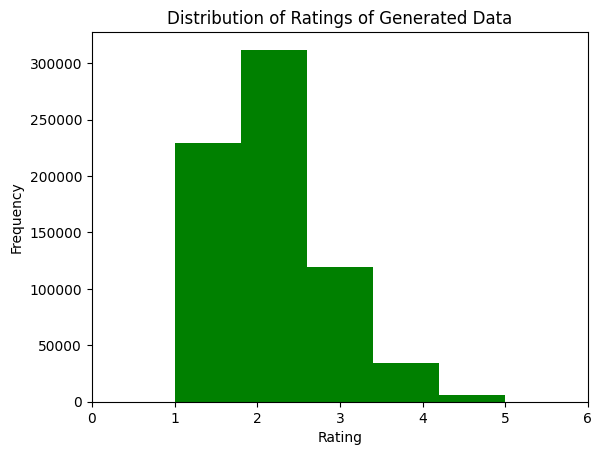

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
plt.hist(df_fake['Rating'], bins = 5, color = 'green')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings of Generated Data')
plt.show()

# cGAN

In [ ]:
latent_dim = 3706
output_dim = 3706
epochs = 50
batch_size = 128
lr_d = 0.00005
lr_g = 0.00003
#조정하기~d를 늘려보자
n_iter_D = 1
n_iter_G = 1

## 평점벡터

In [ ]:
# 생성자 모델
Generator = Sequential()
Generator.add(Dense(128, input_shape=(latent_dim,), activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())

Generator.add(Dense(512, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())
Generator.add(Dropout(0.3))

Generator.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())
Generator.add(Dropout(0.3))

#output_dim보다 커야함
Generator.add(Dense(4096, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())

Generator.add(Dense(output_dim, activation='relu'))


# 판별자 모델
Discriminator = Sequential()
Discriminator.add(Dense(1028, input_shape=(output_dim,), activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())

Discriminator.add(Dense(512, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(256, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(128, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(1, activation='sigmoid'))


Doptimizer = tf.keras.optimizers.Adam(lr_d)
Goptimizer = tf.keras.optimizers.Adam(lr_g)


def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

loss_D_list = []
loss_G_list = []
loss_GD_list = []

for epoch in tf.range(epochs):
    batch_input = y_train.sample(n=batch_size)
    missing = batch_input.applymap(lambda x: 1 if x > 0 else 0)

    inputs = tf.Variable(batch_input.values, tf.float32)
    missing_array = tf.Variable(missing.values, tf.float32)
    inputs = tf.cast(inputs, tf.float32)
    missing_array = tf.cast(missing_array, tf.float32)

    #with tf.GradientTape() as t1, tf.GradientTape() as t2:
    with tf.GradientTape(persistent=True) as t1, tf.GradientTape(persistent=True) as t2:


      for iter in range(n_iter_G):
        #noise와 cgan_inputs 합치기기

        cgan_data = y_train.sample(n=batch_size//2)
        cgan_inputs = tf.Variable(cgan_data.values, tf.float32)
        cgan_inputs = tf.cast(cgan_inputs, tf.float32)
        noise = get_noise(batch_size//2,latent_dim)
        inputs_add_noise = np.concatenate((noise, cgan_inputs), axis=0)

        generated_data = Generator(inputs_add_noise)
        G = generated_data * missing_array
        Z = Discriminator(G)
        loss_G = -tf.reduce_mean(tf.math.log(Z))
        Ggradients = t2.gradient(loss_G,Generator.trainable_variables)
        #inf 방지??
        Ggradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients]
        Goptimizer.apply_gradients(zip(Ggradients, Generator.trainable_variables))

      for iter in range(n_iter_D):
        cgan_data = y_train.sample(n=batch_size//2)
        cgan_inputs = tf.Variable(cgan_data.values, tf.float32)
        cgan_inputs = tf.cast(cgan_inputs, tf.float32)
        noise = get_noise(batch_size//2,latent_dim)
        inputs_add_noise = np.concatenate((noise, cgan_inputs), axis=0)

        generated_data = Generator(inputs_add_noise)

        G = generated_data * missing_array
        Z = Discriminator(G)
        R = Discriminator(inputs)
        # 둘 다 minimize
        loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))
        #loss_G = -tf.reduce_mean(tf.math.log(Z))
        Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
        #inf 방지??
        Dgradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Dgradients]
        Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))

    loss_D_list.append(loss_D)
    loss_G_list.append(loss_G)
    loss_GD_list.append(loss_D+loss_G)

    print(f'Epoch: {epoch}, Discriminator Loss: {loss_D}, Generator Loss: {loss_G}, GAN Loss: {loss_D+loss_G}')
    #print(f"epoch: {epoch} d_loss: {loss_D} g_loss: {loss_G}")

Epoch: 0, Discriminator Loss: 1.3407403230667114, Generator Loss: 0.692238450050354, GAN Loss: 2.0329787731170654
Epoch: 1, Discriminator Loss: 1.2262532711029053, Generator Loss: 0.6886626482009888, GAN Loss: 1.914915919303894
Epoch: 2, Discriminator Loss: 1.118340253829956, Generator Loss: 0.6858381032943726, GAN Loss: 1.8041783571243286
Epoch: 3, Discriminator Loss: 1.0399236679077148, Generator Loss: 0.6832374334335327, GAN Loss: 1.7231611013412476
Epoch: 4, Discriminator Loss: 0.9833142757415771, Generator Loss: 0.6766669750213623, GAN Loss: 1.6599812507629395
Epoch: 5, Discriminator Loss: 0.9736863374710083, Generator Loss: 0.6780730485916138, GAN Loss: 1.651759386062622
Epoch: 6, Discriminator Loss: 0.917243480682373, Generator Loss: 0.6709563732147217, GAN Loss: 1.5881998538970947
Epoch: 7, Discriminator Loss: 0.9201862812042236, Generator Loss: 0.6725150942802429, GAN Loss: 1.5927014350891113
Epoch: 8, Discriminator Loss: 0.8989845514297485, Generator Loss: 0.6596124172210693,

epoch 50 : 3분 27초

두 손실 함수 중 하나만 감소하는 것을 선택하는 것은 상황에 따라 다릅니다. 예를 들어, loss_g만 감소하면서 loss_d가 증가하는 경우, 생성자가 더 이상 학습할 부분이 없어지거나 과적합(overfitting)이 발생할 가능성이 높습니다. 따라서 이러한 상황에서는 loss_d를 개선하기 위한 추가적인 학습 전략이 필요합니다.

반면에, loss_d만 감소하면서 loss_g가 증가하는 경우, 생성자가 더 많은 학습을 진행해야 하며, 이러한 상황에서는 생성자의 학습률(learning rate)을 조절하여 개선할 수 있습니다.

loss의 주기성은 g와 d의 레이어 개수가 다르면 발생할 수 있다.

In [ ]:
df_ratings_create = pd.DataFrame(generated_data, columns = ratings_df.columns)
df_ratings_create.index = range(10001, 10001+len(df_ratings_create))

In [ ]:
df_ratings_create

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
10001,4.180165,3.358937,2.237177,0.970095,0.0,3.949100,1.099406,0.0,0.114166,2.051749,...,0.00000,1.347628,0.0,0.0,2.234874,3.079673,2.728335,0.291602,0.0,2.630131
10002,3.241024,2.253919,1.570414,0.894004,0.0,3.005195,0.893110,0.0,0.000000,1.590191,...,0.00000,1.099146,0.0,0.0,1.413635,2.210977,2.016896,0.482722,0.0,1.993961
10003,2.745487,1.976724,1.525290,0.678593,0.0,2.652321,0.723314,0.0,0.200443,1.291291,...,0.00000,0.892733,0.0,0.0,1.108969,1.708957,1.744259,0.124523,0.0,1.809842
10004,3.545294,2.644717,1.944862,0.785369,0.0,3.558957,0.980648,0.0,0.052322,1.752227,...,0.00000,1.154903,0.0,0.0,1.618289,2.628945,2.055996,0.296736,0.0,2.478015
10005,4.280488,3.078156,2.512153,1.268871,0.0,4.565666,1.210805,0.0,0.108826,2.027578,...,0.00000,1.281535,0.0,0.0,1.902639,3.152417,2.888489,0.609765,0.0,2.803007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2.684127,2.047875,1.409440,0.660016,0.0,2.633403,0.974083,0.0,0.059907,1.265344,...,0.00000,0.767516,0.0,0.0,1.313652,1.787288,1.753632,0.289424,0.0,1.740754
10125,3.892952,2.928645,1.992584,1.061846,0.0,3.778082,1.245642,0.0,0.215920,1.733957,...,0.00000,1.176718,0.0,0.0,1.762375,2.726397,2.493769,0.165851,0.0,2.594836
10126,10.750080,8.154989,5.753798,2.415429,0.0,9.884304,3.143705,0.0,0.456809,4.698130,...,0.00000,3.191954,0.0,0.0,4.802136,7.198022,6.560582,1.010780,0.0,6.986770
10127,20.014048,14.618689,9.388800,3.875334,0.0,18.030575,6.281902,0.0,0.501628,8.374928,...,0.00000,5.148834,0.0,0.0,8.961623,12.682374,11.677999,1.998995,0.0,12.735324


In [ ]:
max_val = df_ratings_create.max().max()
print(max_val)

31.473276


In [ ]:
zero_cols = (df_ratings_create == 0).all(axis=0).sum()
print(zero_cols)

1102


In [ ]:
df = df_ratings_create.copy()

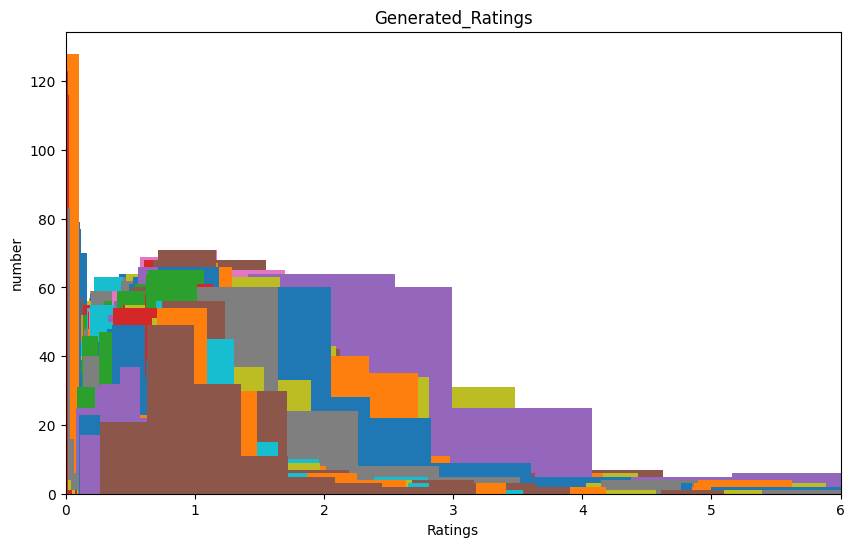

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df.columns:
  plt.hist(df[column_name])
plt.xlim(0, 6)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

<Axes: xlabel='MovieID'>

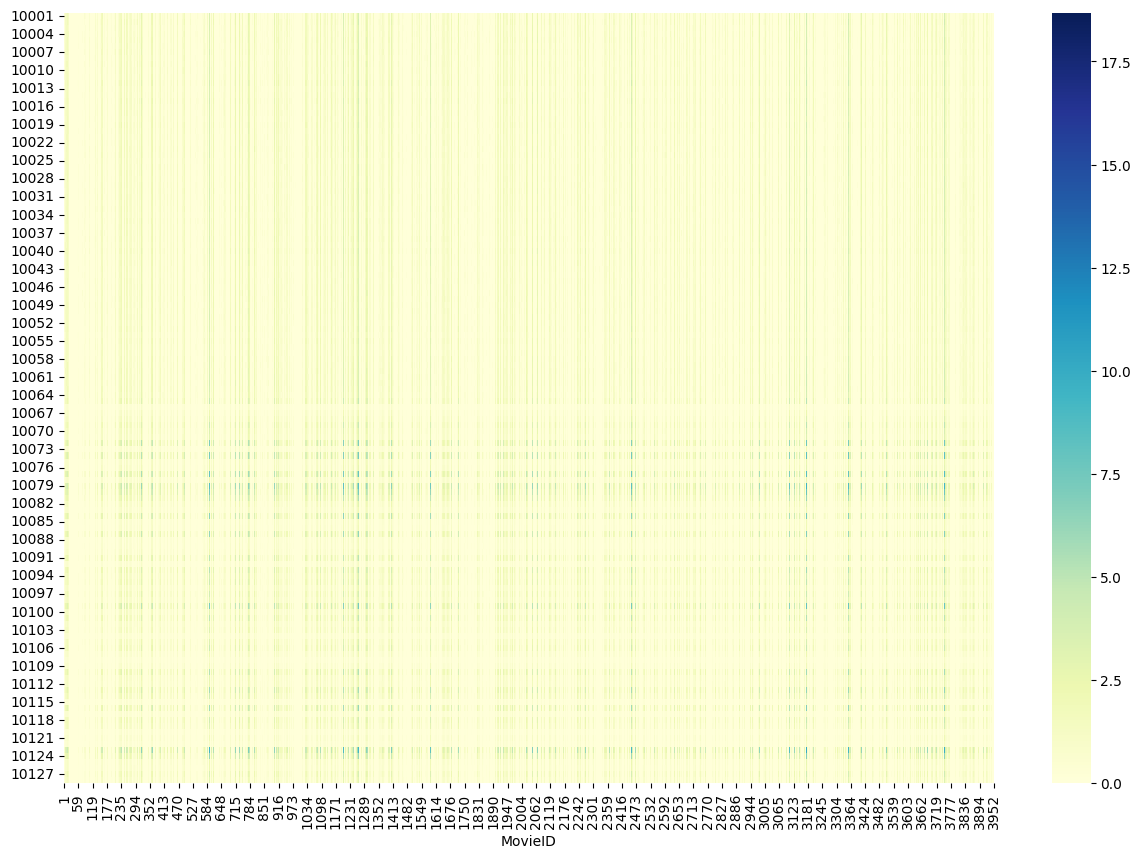

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df, cmap='YlGnBu', ax=ax)

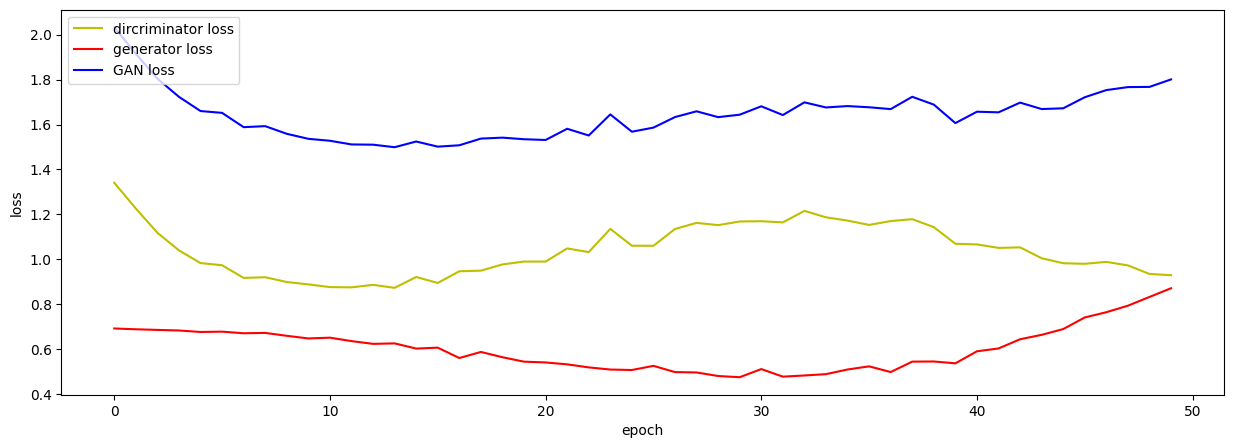

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(loss_D_list, 'y', label = 'dircriminator loss')
loss_ax.plot(loss_G_list, 'r', label = 'generator loss')
loss_ax.plot(loss_GD_list, 'b', label = 'GAN loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

##결측벡터

In [ ]:
latent_dim = 100
output_dim = 3706
epochs = 50
batch_size = 128
lr_d = 0.00005
lr_g = 0.00003
#조정하기~d를 늘려보자
n_iter_D = 2
n_iter_G = 1

In [ ]:
# 생성자 모델
Generator = Sequential()
Generator.add(Dense(128, input_shape=(latent_dim,), activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())

Generator.add(Dense(512, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())
Generator.add(Dropout(0.3))

Generator.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())
Generator.add(Dropout(0.3))

#output_dim보다 커야함
Generator.add(Dense(4096, activation=LeakyReLU(0.2)))
Generator.add(BatchNormalization())

Generator.add(Dense(output_dim, activation='relu'))


# 판별자 모델
Discriminator = Sequential()
Discriminator.add(Dense(1028, input_shape=(output_dim,), activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())

Discriminator.add(Dense(512, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(256, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(128, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(1, activation='sigmoid'))


Doptimizer = tf.keras.optimizers.Adam(lr_d)
Goptimizer = tf.keras.optimizers.Adam(lr_g)


def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

loss_D_list = []
loss_G_list = []
loss_GD_list = []

for epoch in tf.range(epochs):
    batch_input = X_train.sample(n=batch_size)


    #with tf.GradientTape() as t1, tf.GradientTape() as t2:
    with tf.GradientTape(persistent=True) as t1, tf.GradientTape(persistent=True) as t2:


      for iter in range(n_iter_G):
        generated_data = Generator(get_noise(batch_size,latent_dim))
        Z = Discriminator(generated_data)
        loss_G = -tf.reduce_mean(tf.math.log(Z))
        Ggradients = t2.gradient(loss_G,Generator.trainable_variables)
        #inf 방지??
        Ggradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients]
        Goptimizer.apply_gradients(zip(Ggradients, Generator.trainable_variables))

      for iter in range(n_iter_D):
        generated_data = Generator(get_noise(batch_size,latent_dim))
        Z = Discriminator(generated_data)
        R = Discriminator(inputs)
        # 둘 다 minimize
        loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))
        #loss_G = -tf.reduce_mean(tf.math.log(Z))
        Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
        #inf 방지??
        Dgradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Dgradients]
        Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))

    loss_D_list.append(loss_D)
    loss_G_list.append(loss_G)
    loss_GD_list.append(loss_D+loss_G)

    print(f'Epoch: {epoch}, Discriminator Loss: {loss_D}, Generator Loss: {loss_G}, GAN Loss: {loss_D+loss_G}')
    #print(f"epoch: {epoch} d_loss: {loss_D} g_loss: {loss_G}")

Epoch: 0, Discriminator Loss: 1.4291062355041504, Generator Loss: 0.7161720991134644, GAN Loss: 2.1452784538269043
Epoch: 1, Discriminator Loss: 1.376314401626587, Generator Loss: 0.6930912733078003, GAN Loss: 2.0694055557250977
Epoch: 2, Discriminator Loss: 1.3093664646148682, Generator Loss: 0.682380199432373, GAN Loss: 1.9917466640472412
Epoch: 3, Discriminator Loss: 1.2749483585357666, Generator Loss: 0.6720225811004639, GAN Loss: 1.9469709396362305
Epoch: 4, Discriminator Loss: 1.2267889976501465, Generator Loss: 0.6669814586639404, GAN Loss: 1.893770456314087
Epoch: 5, Discriminator Loss: 1.187170386314392, Generator Loss: 0.6633678674697876, GAN Loss: 1.8505382537841797
Epoch: 6, Discriminator Loss: 1.1297106742858887, Generator Loss: 0.6638801097869873, GAN Loss: 1.793590784072876
Epoch: 7, Discriminator Loss: 1.1258471012115479, Generator Loss: 0.6686474680900574, GAN Loss: 1.79449462890625
Epoch: 8, Discriminator Loss: 1.0840392112731934, Generator Loss: 0.6754561066627502, G

In [ ]:
df_missing_create = pd.DataFrame(generated_data, columns = ratings_df.columns)
df_missing_create.index = range(10001, 10001+len(df_missing_create))
df_missing_create = df_missing_create.rename_axis("UserID")

In [ ]:
df_missing_create

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
10001,0.0,0.000000,0.077285,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010808,...,0.009251,0.0,0.009669,0.069953,0.0,0.093072,0.001897,0.0,0.0,0.000000
10002,0.0,0.000000,0.193691,0.0,0.044566,0.000000,0.0,0.0,0.0,0.159283,...,0.102340,0.0,0.000000,0.003332,0.0,0.133527,0.000000,0.0,0.0,0.004817
10003,0.0,0.000000,0.147183,0.0,0.000000,0.000000,0.0,0.0,0.0,0.117508,...,0.000000,0.0,0.000000,0.000000,0.0,0.096322,0.002516,0.0,0.0,0.000000
10004,0.0,0.060832,0.135926,0.0,0.008075,0.000000,0.0,0.0,0.0,0.151864,...,0.000991,0.0,0.000000,0.028022,0.0,0.060761,0.087388,0.0,0.0,0.000000
10005,0.0,0.023628,0.052314,0.0,0.014147,0.000000,0.0,0.0,0.0,0.042297,...,0.009039,0.0,0.000000,0.000000,0.0,0.061937,0.018287,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,0.0,0.000000,0.134200,0.0,0.000000,0.000000,0.0,0.0,0.0,0.181036,...,0.067120,0.0,0.024598,0.010674,0.0,0.038000,0.034621,0.0,0.0,0.000000
10125,0.0,0.000000,0.114342,0.0,0.000000,0.025255,0.0,0.0,0.0,0.155743,...,0.059226,0.0,0.000000,0.000000,0.0,0.090542,0.000000,0.0,0.0,0.000000
10126,0.0,0.102329,0.163641,0.0,0.068486,0.000000,0.0,0.0,0.0,0.147880,...,0.093636,0.0,0.008807,0.000000,0.0,0.088301,0.000000,0.0,0.0,0.000000


In [ ]:
max_val = df_missing_create.max().max()
print(max_val)

0.59774226


In [ ]:
zero_cols = (df_missing_create == 0).all(axis=0).sum()
print(zero_cols)

814


In [ ]:
df_missing = df_missing_create.copy()

In [ ]:
df_missing.to_csv(path + 'df_missing.csv', index=True, header=True)

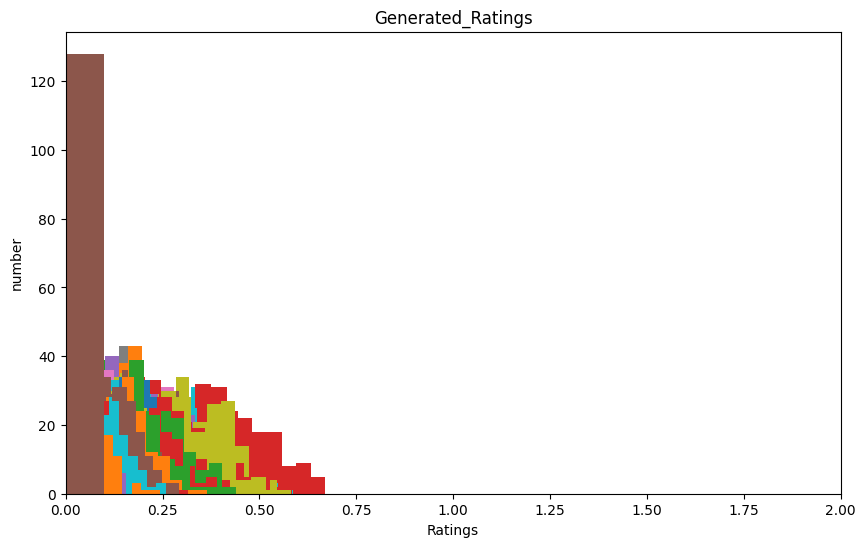

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df_missing.columns:
  plt.hist(df_missing[column_name])
plt.xlim(0, 2)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

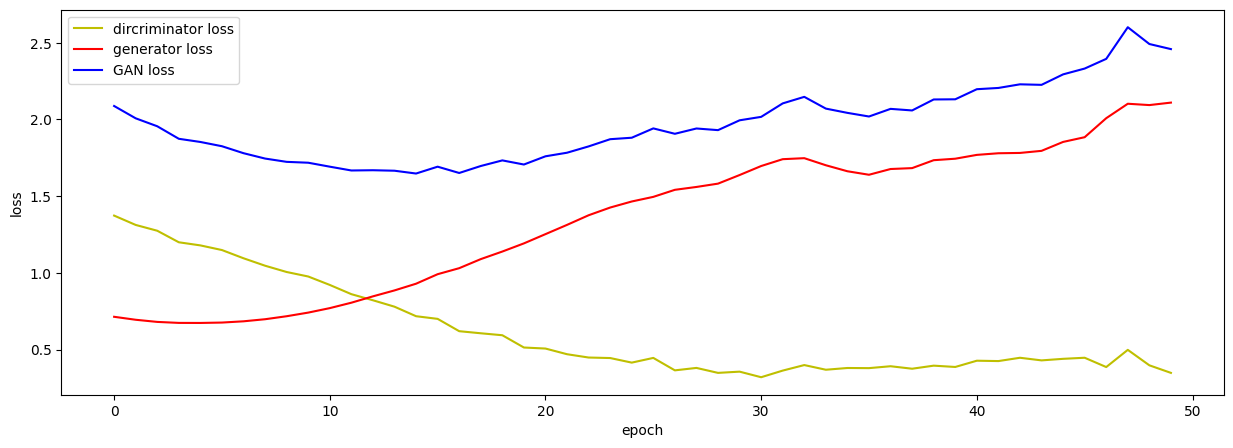

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(loss_D_list, 'y', label = 'dircriminator loss')
loss_ax.plot(loss_G_list, 'r', label = 'generator loss')
loss_ax.plot(loss_GD_list, 'b', label = 'GAN loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

## 둘이 합치기

In [ ]:
df = pd.read_csv(path + 'df.csv')
df_missing = pd.read_csv(path + 'df_missing.csv')

missing_df에 ['1':'0'] = [1000209 : 21384031] = [1:21] 비율로 존재

In [ ]:
#20000개 정도 threshold 해볼까
values_flattened = df_missing.values.flatten()  # DataFrame을 1차원 배열로 변환합니다
top_values = sorted(set(values_flattened), reverse=True)[:25000]

In [ ]:
values_flattened = np.where(np.isin(values_flattened, top_values), 1, 0)

# 1차원 배열을 다시 128 * 3706 크기의 데이터프레임으로 변환
df_missing_final = pd.DataFrame(values_flattened.reshape(128, 3706), index=df.index, columns=df.columns)

In [ ]:
df_final = df_missing_final * df

In [ ]:
df_final = np.ceil(df_final)

In [ ]:
counts = df_final.stack().value_counts()

In [ ]:
counts

0.0    459047
2.0      7030
1.0      3753
3.0      3462
4.0       802
5.0       235
6.0        39
dtype: int64

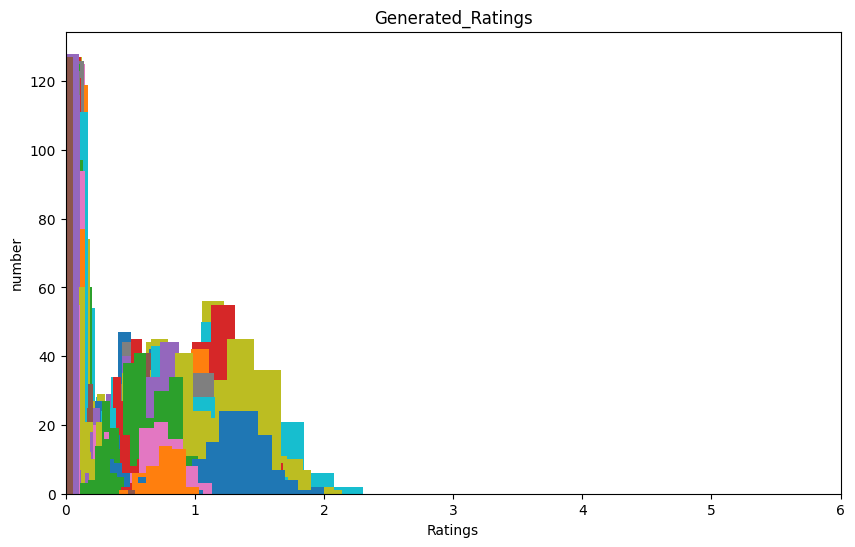

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df_final.columns:
  plt.hist(df_final[column_name])
plt.xlim(0, 6)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

In [ ]:
df_final.index.name = 'UserID'
df_final.columns.name = 'MovieID'
df_final.name = 'Rating'

# UMAP

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=bd3c5a91d114ab7eae23dcf49d61cbc3d0fbe3244edab1ae258c5064650f3eb6
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=011512773bffb1fa7fd92c7ba9b34dfb38d02203b7cdbbd9f9ba5d6de07bff31
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:
df_fake = pd.read_csv(path + 'df_fake.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


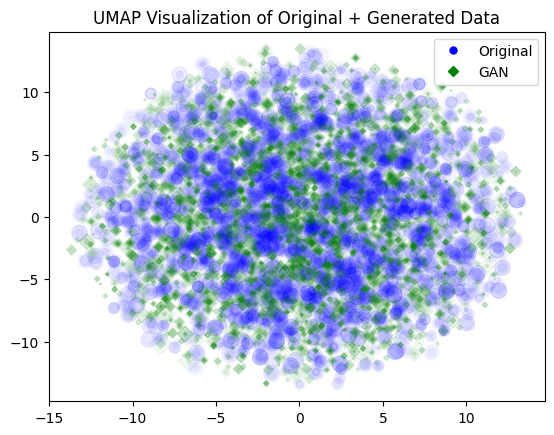

In [ ]:
size = 10000

ratings_sample = ratings.sample(size, random_state=100).reset_index(drop=True)
fake_sample = df_fake.sample(size, random_state=100).reset_index(drop=True)

merged_sample = pd.concat([ratings_sample, fake_sample], axis = 0).reset_index(drop=True)

# 평점 데이터를 가져와서 점의 크기로 사용할 수 있도록 전처리
ratings_real = merged_sample['Rating'].values
# 점의 크기는 평점에 비례하도록 설정

sizes_real = ratings_real[:size]**3
sizes_fake = ratings_real[size:]**3

# umap을 사용하여 데이터를 저차원으로 투영
reducer_real = umap.UMAP(n_neighbors = 3, random_state=100)
embedding_real = reducer_real.fit_transform(merged_sample[['MovieID', 'UserID']].values)


# movie_id = 1
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]+1),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )

# movie_id = 356
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]+1),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )

# movie_id = 3114
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]+1),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )

# # 새로 생성된 데이터
# movie_id = 1159
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]-3),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )


# 시각화
plt.scatter(embedding_real[:size, 0], embedding_real[:size, 1], s=sizes_real, alpha=0.03, color='blue', label='Original')
plt.scatter(embedding_real[size:, 0], embedding_real[size:, 1], s=sizes_fake, alpha=0.05, color='green', marker='D', label='GAN')
plt.title('UMAP Visualization of Original + Generated Data')
# 범례 추가
legend_markers = [plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=5),
                  plt.Line2D([0], [0], color='green', marker='D', linestyle='', markersize=5)]
legend_labels = ['Original', 'GAN']
plt.legend(legend_markers, legend_labels)
plt.show()

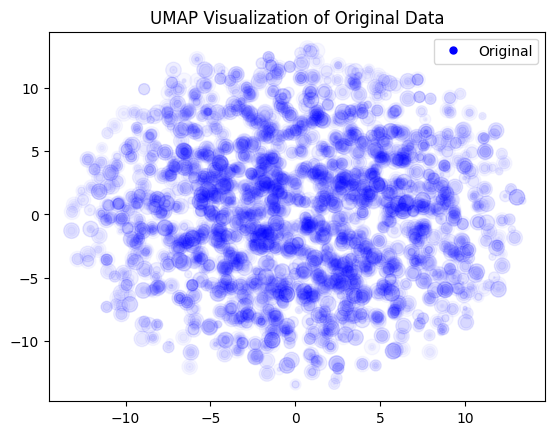

In [ ]:
# movie_id = 1
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]+1),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )

# movie_id = 356
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]+1),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )

# movie_id = 3114
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]+1),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )

# # 새로 생성된 데이터
# movie_id = 1159
# movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
# movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
# plt.annotate(movie_name,
#              xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
#              xytext=(embedding_real[movie_index, 0]-1, embedding_real[movie_index, 1]-3),
#              xycoords='data',
#              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#              horizontalalignment='right', verticalalignment='top',
#             )




# 시각화
plt.scatter(embedding_real[:size, 0], embedding_real[:size, 1], s=sizes_real, alpha=0.03, color='blue', label='Original')
plt.title('UMAP Visualization of Original Data')
# 범례 추가
legend_markers = [plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=5)]
legend_labels = ['Original']
plt.legend(legend_markers, legend_labels)
plt.show()

In [ ]:
movie_id_list = movies['MovieID'].tolist()
ratings_movie_list = ratings['MovieID'].tolist()

not_in_movie_list = []
for movie_id in movie_id_list:
  if movie_id not in ratings_movie_list:
    not_in_movie_list.append(movie_id)

In [ ]:
# 'title' 열에서 'toy story' 단어가 포함된 영화 찾기
toy_story_movies = movies[movies['Title'].str.contains('toy story', case=False)]

print(toy_story_movies)

      MovieID               Title                       Genres
0           1    Toy Story (1995)  Animation|Children's|Comedy
3045     3114  Toy Story 2 (1999)  Animation|Children's|Comedy


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


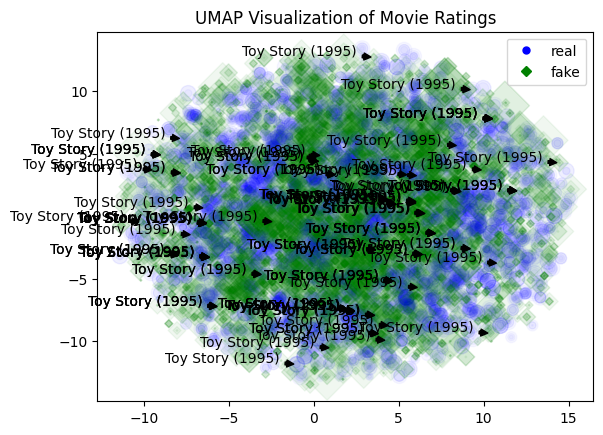

In [ ]:
size = 10000

ratings_sample = ratings.sample(size, random_state=100).reset_index(drop=True)
fake_sample = df_fake.sample(size, random_state=100).reset_index(drop=True)

merged_sample = pd.concat([ratings_sample, fake_sample], axis = 0).reset_index(drop=True)

# 평점 데이터를 가져와서 점의 크기로 사용할 수 있도록 전처리
ratings_real = merged_sample['Rating'].values
# 점의 크기는 평점에 비례하도록 설정

sizes_real = ratings_real[:size]**3
sizes_fake = ratings_real[size:]**4

# umap을 사용하여 데이터를 저차원으로 투영
reducer_real = umap.UMAP(n_neighbors = 3, random_state=100)
embedding_real = reducer_real.fit_transform(merged_sample[['MovieID', 'UserID']].values)


movie_id = 1
movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index
movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
for movie_index_one in movie_index:
  plt.annotate(movie_name,
              xy=(embedding_real[movie_index_one, 0], embedding_real[movie_index_one, 1]),
              xytext=(embedding_real[movie_index_one, 0]-1, embedding_real[movie_index_one, 1]+1),
              xycoords='data',
              arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
              horizontalalignment='right', verticalalignment='top',
              )



# 시각화
plt.scatter(embedding_real[:size, 0], embedding_real[:size, 1], s=sizes_real, alpha=0.03, color='blue', label='real')
plt.scatter(embedding_real[size:, 0], embedding_real[size:, 1], s=sizes_fake, alpha=0.06, color='green', marker='D', label='real')
plt.title('UMAP Visualization of Movie Ratings')
# 범례 추가
legend_markers = [plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=5),
                  plt.Line2D([0], [0], color='green', marker='D', linestyle='', markersize=5)]
legend_labels = ['real', 'fake']
plt.legend(legend_markers, legend_labels)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


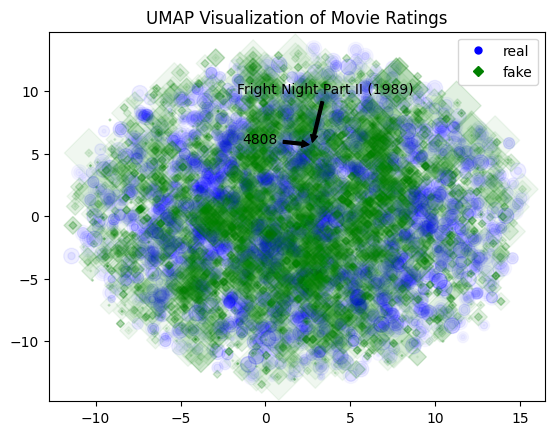

In [ ]:
size = 10000

ratings_sample = ratings.sample(size, random_state=100).reset_index(drop=True)
fake_sample = df_fake.sample(size, random_state=100).reset_index(drop=True)

merged_sample = pd.concat([ratings_sample, fake_sample], axis = 0).reset_index(drop=True)

# 평점 데이터를 가져와서 점의 크기로 사용할 수 있도록 전처리
ratings_real = merged_sample['Rating'].values
# 점의 크기는 평점에 비례하도록 설정

sizes_real = ratings_real[:size]**3
sizes_fake = ratings_real[size:]**4

# umap을 사용하여 데이터를 저차원으로 투영
reducer_real = umap.UMAP(n_neighbors = 3, random_state=100)
embedding_real = reducer_real.fit_transform(merged_sample[['MovieID', 'UserID']].values)


user_id = 4808
user_index = merged_sample[merged_sample['UserID'] == user_id].index[1]
plt.annotate(user_id,
            xy=(embedding_real[user_index, 0], embedding_real[user_index, 1]),
            xytext=(embedding_real[user_index, 0]-2, embedding_real[user_index, 1]+1),
            xycoords='data',
            arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
            horizontalalignment='right', verticalalignment='top',
            )
# for user_index_one in user_index:
#   plt.annotate(user_id,
#               xy=(embedding_real[user_index_one, 0], embedding_real[user_index_one, 1]),
#               xytext=(embedding_real[user_index_one, 0]-1, embedding_real[user_index_one, 1]+1),
#               xycoords='data',
#               arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#               horizontalalignment='right', verticalalignment='top',
#               )


movie_id = 2868
movie_index = merged_sample[merged_sample['MovieID'] == movie_id].index[0]
movie_name = movies.loc[movies['MovieID'] == movie_id, 'Title'].item()
plt.annotate(movie_name,
            xy=(embedding_real[movie_index, 0], embedding_real[movie_index, 1]),
            xytext=(embedding_real[movie_index, 0]+6, embedding_real[movie_index, 1]+5),
            xycoords='data',
            arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
            horizontalalignment='right', verticalalignment='top',
            )
# for movie_index_one in movie_index:
#   plt.annotate(movie_name,
#               xy=(embedding_real[movie_index_one, 0], embedding_real[movie_index_one, 1]),
#               xytext=(embedding_real[movie_index_one, 0]+3, embedding_real[movie_index_one, 1]+3),
#               xycoords='data',
#               arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
#               horizontalalignment='right', verticalalignment='top',
#               )


# 시각화
plt.scatter(embedding_real[:size, 0], embedding_real[:size, 1], s=sizes_real, alpha=0.03, color='blue', label='real')
plt.scatter(embedding_real[size:, 0], embedding_real[size:, 1], s=sizes_fake, alpha=0.06, color='green', marker='D', label='real')
plt.title('UMAP Visualization of Movie Ratings')
# 범례 추가
legend_markers = [plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=5),
                  plt.Line2D([0], [0], color='green', marker='D', linestyle='', markersize=5)]
legend_labels = ['real', 'fake']
plt.legend(legend_markers, legend_labels)
plt.show()

### pivot

In [ ]:
#평점 df
movie_id_list = movies['MovieID'].tolist()
df_pivot = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value = 0)
df_pivot = df_pivot.reindex(columns=movie_id_list, fill_value=0)

In [ ]:
df_pivot

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,2,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#평점 df
df_fake_pivot = df_fake.pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value = 0)
df_fake_pivot = df_fake_pivot.reindex(columns=movie_id_list, fill_value=0)

In [ ]:
df_fake_pivot

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
10001,3,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,3,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10005,3,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14093,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14094,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


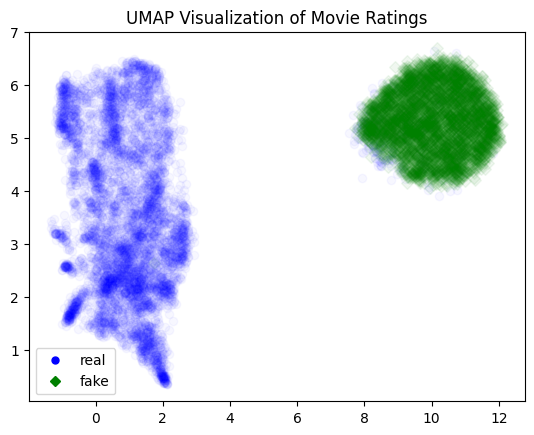

In [ ]:
size = df_pivot.shape[0]

merged_sample = pd.concat([df_pivot, df_fake_pivot], axis = 0).reset_index(drop=True)


# 평점 데이터를 가져와서 점의 크기로 사용할 수 있도록 전처리
#ratings_real = merged_sample['Rating'].values
# 점의 크기는 평점에 비례하도록 설정

#sizes_real = ratings_real[:size]**3
#sizes_fake = ratings_real[size:]**4

# umap을 사용하여 데이터를 저차원으로 투영
reducer_real = umap.UMAP(n_neighbors = 15, random_state=100)
embedding_real = reducer_real.fit_transform(merged_sample.values)


# 시각화
plt.scatter(embedding_real[:size, 0], embedding_real[:size, 1],  alpha=0.03, color='blue', label='real')
plt.scatter(embedding_real[size:, 0], embedding_real[size:, 1],  alpha=0.06, color='green', marker='D', label='real')
plt.title('UMAP Visualization of Movie Ratings')
# 범례 추가
legend_markers = [plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=5),
                  plt.Line2D([0], [0], color='green', marker='D', linestyle='', markersize=5)]
legend_labels = ['real', 'fake']
plt.legend(legend_markers, legend_labels)
plt.show()

# 발표 준비

In [ ]:
counts = ratings_df.stack().value_counts()

In [ ]:
counts

0    22453111
4      348971
3      261197
5      226310
2      107557
1       56174
dtype: int64

In [ ]:
df_fake = pd.read_csv(path + 'df_fake.csv')

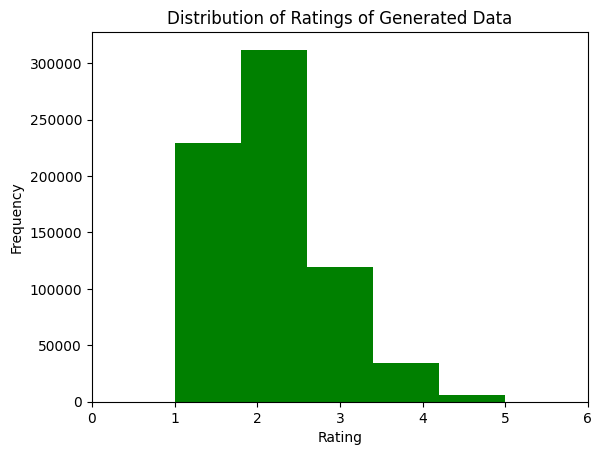

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
plt.hist(df_fake['Rating'], bins = 5, color = 'green')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings of Generated Data')
plt.show()

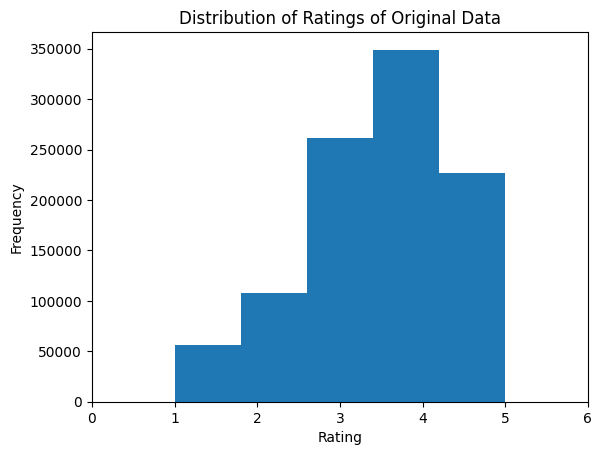

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
plt.hist(ratings['Rating'], bins = 5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings of Original Data')
plt.show()

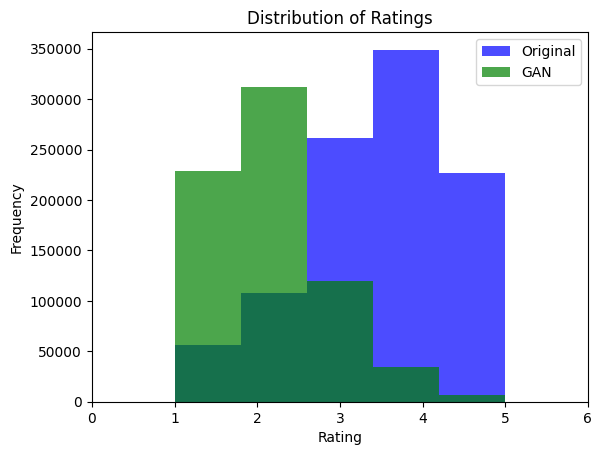

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
plt.hist(ratings['Rating'], bins = 5, color = 'blue', alpha=0.7, label = 'Original')
plt.hist(df_fake['Rating'], bins = 5, color = 'green', alpha = 0.7, label = 'GAN')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Ratings')
plt.show()

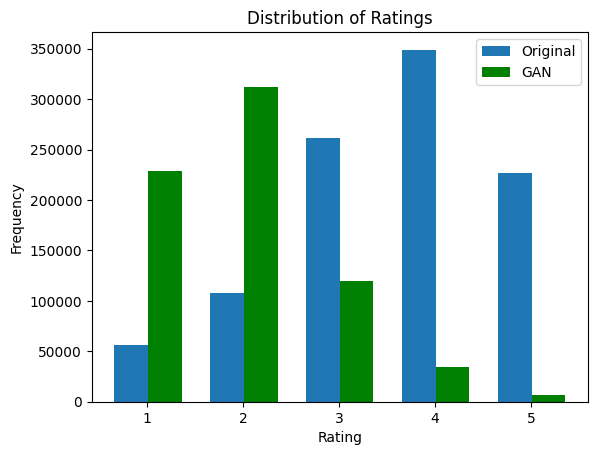

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 두 번째 히스토그램 데이터
ratings_original = ratings['Rating']
bins_original = 5

# 첫 번째 히스토그램 데이터
ratings_fake = df_fake['Rating']
bins_fake = 5


# 막대 폭과 오프셋 설정
bar_width = 0.35
bar_offset = 0.175

# x 좌표 계산
x_original = np.arange(bins_original) + bar_offset
x_fake = np.arange(bins_fake) + bar_offset + bar_width

# 막대 그래프 그리기
plt.bar(x_original, np.histogram(ratings_original, bins=bins_original)[0], bar_width, label='Original')
plt.bar(x_fake, np.histogram(ratings_fake, bins=bins_fake)[0], bar_width, label='GAN', color = 'green')

# # x 축 설정
x_ticks = np.arange(bins_fake) + 0.34
x_labels = np.arange(1, bins_fake + 1)
plt.xticks(x_ticks, x_labels)


# 축과 제목 설정
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.legend()

# 그림 표시
plt.show()


In [ ]:
ratings.drop('Timestamp', axis=1, inplace=True)

In [ ]:
df_combined = pd.concat([ratings, df_fake], axis=0, ignore_index=True)

In [ ]:
df_combined

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1701709,13216,3947,1
1701710,13225,3947,1
1701711,13505,3947,1
1701712,13548,3947,1


In [ ]:
df_combined.to_csv(path + 'df_combined.csv', index=False)

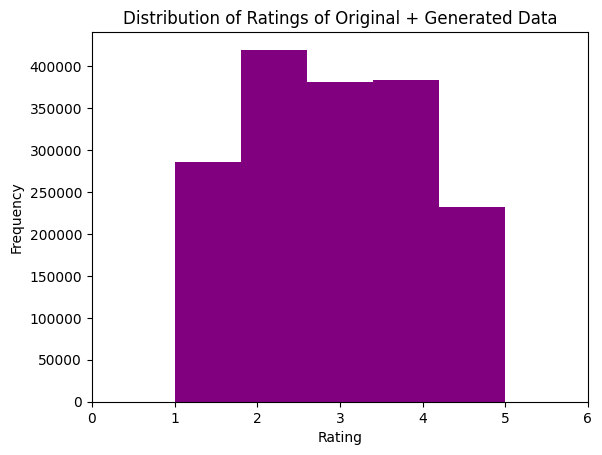

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
plt.hist(df_combined['Rating'], bins = 5, color = 'purple')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings of Original + Generated Data')
plt.show()